In [13]:
import numpy as np
import probnum as pn
from probnum.randprocs.covfuncs import Matern
import matplotlib.pyplot as plt
from scipy.linalg import circulant

Given data $(X_i, y_i)_{i=1}^N$  with 

$y_i= X_i w  +\varepsilon_i \in \mathbb{R}^d$  with $\varepsilon_i$ random vectors (noise) and 

 $X_i \in \mathbb{R}^{d\times d}$ circulant matrices representing discrete circular convolution operators on vectors

here we consider 

$$
\hat{w}_\lambda =\arg\min_{w\in \mathcal{H}} \frac 1 N \sum_{i=1}^N \left\lVert X_i  w - y_i\right\lVert_{\mathbb{R}^d}^2+\lambda \left\lVert w \right\lVert_\mathcal{H}^2, \quad \quad \lambda>0 
$$

where $\mathcal{H} \subset \mathbb{R}^d$ is RKHS, and implement
$$
\hat{w}_\lambda = S^\ast ( S S^\ast + \lambda I) ^{-1} Y
$$

where $S$ is the sampling operator.

In [14]:
#Inference functions 


def S_star_operator(Y, X ,ker_mat, t_right, t_left, N, d):
    
    S_star = ker_mat.T @ sum(X[i].T @ Y[:,i] for i in range(N)) *( (t_right-t_left)/(N*d) )
    
    return S_star


def S_S_star_matrix(Y, X ,ker_mat, t_right, t_left, N, d):
    
    # this is a tensor reshaped in the appropriate form to be able to compute the inverse in the inference 
    
    SS_star_tensor = np.zeros((N,N,d,d))
    
    for i in range(0,N):
        for j in range(0,N):
            SS_star_tensor[i,j,:,:] = X[i] @ ker_mat @ X[j].T
            
    SS_star_mat = SS_star_tensor.swapaxes(1,2).reshape(d*N,d*N) *( (t_right-t_left)/(N*d) )
    
    return SS_star_mat 

def Kronecker_mat_regul(lam,N,d):

    Sigma_Kron = pn.linops.Kronecker(
        A = (lam) * np.eye(N,N),
        B = np.eye(d,d)
        )    # (dF x dF)
    return Sigma_Kron


def S_star_operator_for_cov(XK, X, k, N, h ):

    S_star =   sum(k @ X[i].T @ XK[i,:,:] for i in range(N)) * (h / N)
    
    return S_star

def Kronecker_mat_regul(lam,N,d):

    Sigma_Kron = pn.linops.Kronecker(
        A = (lam) * np.eye(N,N),
        B = np.eye(d,d)
        )    # (dF x dF)
    return Sigma_Kron


def S_star_operator_for_cov(XK, X, k, N, h ):

    S_star =   sum(k @ X[i].T @ XK[i,:,:] for i in range(N)) * (h / N)
    
    return S_star

In [15]:
def power_law_samples(N, L, alpha):
    """
    Generates N samples drawn from a power law probability distribution on the integers
    with exponent alpha.
    
    Args:
    - N: an integer specifying the number of samples to generate
    -L: the samples are drawn in the interval [1,L+1]
    - alpha: a positive float specifying the exponent of the power law
    
    Returns:
    - A numpy array of N integers drawn from the power law distribution
    """
    # Define the power law probability density function
    def p(x):
        return 1.0 / (x**alpha)
    
    # Define the normalization constant
    Z = sum([p(l) for l in range(1, L+1)])
    
    # Generate the samples
    samples = []
    while len(samples) < N:
        # Choose a random integer in the range [1, L+1] with probability proportional to p(l)
        n = np.random.choice(range(1, L+1), p=[p(l)/Z for l in range(1, L+1)])
        samples.append(n)
    
    return np.array(samples)

In [16]:
#Ground truth functions 

def sin_polinom(t,alpha,M):
    return sum((np.sin(2*np.pi*j*t) / (j**alpha)) for j in range(1,M+1))

#CHOOSE number of input functions
N = 20   # number of samples
num_exp = 5 #number of times for each N

d = 100 # grid points

t_left = 0
t_right = 1
t = np.linspace(t_left,t_right,d)

#CHOOSE ground truth function and obs. noise         y_i = x_i * true_w + noise
beta = .4
sum_until = 90
true_w = sin_polinom(t,beta,sum_until)                        

noise = 0.05

L_until = sum_until
samples_decay = .8

delta = 0.076
alpha = .7 * (beta / samples_decay)


In [17]:
#kernel
def Dirichlet(t,s,p):
    return (2*p + 1)* ( np.sinc( (2*p + 1) * (t-s)  ) / np.sinc(t-s) )


def kernel_fun(f):
    return lambda a, b: np.array(
        [[np.float64(f(a[i], b[j])) for j in range(b.size)]
         for i in range(a.size)]
    )

p = sum_until

k = kernel_fun(lambda a, b: Dirichlet(a,b,p))
k0 = k(t[:,None], t[:,None])

m = np.zeros((len(t),))

/tmp/ipykernel_18249/1722745002.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [[np.float64(f(a[i], b[j])) for j in range(b.size)]


In [18]:
#prepare error arrays
error_sampmean = np.zeros(N)
error_sampstd = np.zeros(N)
error_logmea = np.zeros(N)
error_logstd = np.zeros(N)

In [19]:
#Inference and compute L2 errors
for n in range(1,N+1):
    
    error_of_exper = np.zeros(num_exp)
    
    for j in range(0,num_exp):
    

        #Localized in frequency
        #random vector for frequencies
        L = power_law_samples(n, L_until, samples_decay)
        X =  np.array([ np.cos(l*t*2*np.pi) + 1j*np.sin(l*t*2*np.pi)  for l in L]).T
        
         #Localized in time
        # L = np.random.normal(.5,.2,n)

        # X = np.array([np.where(((t-l) <= 2*delta) & ((t-l)>=0), 1, 0) for l in L]).T / (2*delta)


        X_operators = np.zeros((n,d,d))    # Input operators
        for i in range(0,n):
            X_operators[i,:,:] =circulant(X[:,i])   

        #Output data matrix 
        Y = np.zeros((d,n))   #noisy 
        for i in range(0,n):
            Y[:,i] = np.real(np.fft.ifft(np.fft.fft(true_w)*np.fft.fft(X[:,i]))) +  noise  * np.random.normal(0,1,d) 

#         print(L)

        lamb =  1e-4 * (n**(-(alpha+2)**(-1)) )
        SS_star_mat = S_S_star_matrix(Y = Y, X = X_operators, ker_mat = k0, t_right = t_right, t_left = t_left, N = n, d = d)
        lam_kron_mat = Kronecker_mat_regul(lam = lamb, N=n, d=d)
        # Inference  
        G = SS_star_mat + lam_kron_mat
        GY = G.inv() @ Y.T.reshape(d*n,) #np.linalg.solve(G, Y.T.reshape(d*N,))   
        GY = GY.reshape(n,d).T
        w = S_star_operator(GY, X = X_operators, ker_mat = k0, t_right = t_right, t_left = t_left, N = n, d = d)

        error_of_exper[j] = (np.square(w - true_w)).sum() 
    
    error_sampmean[n-1] = np.mean(error_of_exper)     #error_of_exp.sum() / num_exp
    error_sampstd[n-1] = np.std(error_of_exper)        #np.sqrt((np.square(error_of_exp - error_sampmean[n-1] )).sum() / (num_exp-1))
    error_logmea[n-1] = np.mean(np.log(error_of_exper))
    error_logstd[n-1] = np.std(np.log(error_of_exper))

/tmp/ipykernel_18249/611043327.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  X_operators[i,:,:] =circulant(X[:,i])


Text(0, 0.5, 'Error \\   $ \\parallel \\tilde{w} - w^* \\parallel_{L^2} ^2$')

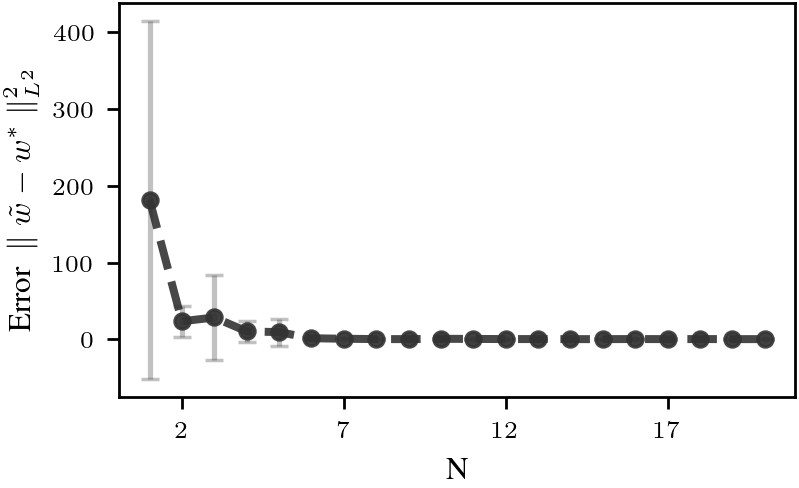

In [20]:
from tueplots import  bundles
plt.rcParams.update({"figure.dpi": 250})
#define colors
red = np.array([141.0, 45.0, 57.0]) / 255.0
dark = np.array([51.0, 51.0, 51.0]) / 255.0
index = np.arange(1,N+1)

plt.rcParams.update(bundles.aistats2023())
fig, ax = plt.subplots(1,  )

ax.plot(index,error_sampmean,"o--",markersize=4.3, color=dark, alpha =.9,linewidth = 2.3)
ax.errorbar(index, error_sampmean, yerr =error_sampstd, color=dark, fmt='o', alpha=.3, capsize=2.5,ms=2)


# ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_xticks(index[1::5])
ax.set_ylabel(r'Error \   $ \parallel \tilde{w} - w^* \parallel_{L^2} ^2$')
# ax.legend()
    


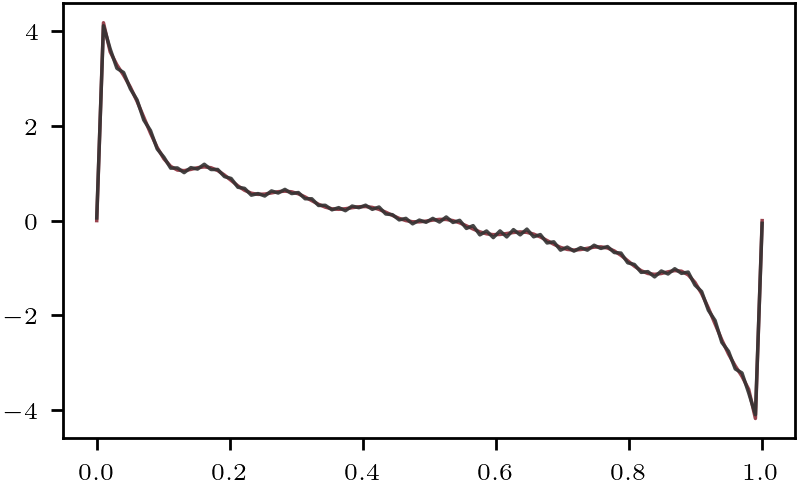

In [21]:
plt.plot(t,true_w,linewidth = 1, color=red, alpha =.9)
plt.plot(t,w,linewidth = 1, color=dark, alpha =.9)